In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!pip install tensorflow_text==2.10.0

In [ ]:
import sys
import tensorflow as tf
import numpy as np

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

In [2]:
import tensorflow_text as text

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [7]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [9]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [13]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
3792,spam,"Twinks, bears, scallies, skins and jocks are c...",1
3276,ham,Hurry home u big butt. Hang up on your last ca...,0
1253,ham,Yeah like if it goes like it did with my frien...,0
1325,ham,Can you call me plz. Your number shows out of ...,0
2664,spam,8007 FREE for 1st week! No1 Nokia tone 4 ur mo...,1


In [14]:
#Podeli u trening i testing dataset

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [17]:
X_train.head(4)

5160                       Ok... Then r we meeting later?
3201    Just curious because my cuz asked what I was u...
5098    TheMob>Hit the link to get a premium Pink Pant...
3146           I.ll get there tomorrow and send it to you
Name: Message, dtype: object

In [18]:
# Import Pretrained BERT model i vektorske reprezentacije re;i u formi word embeddinga

In [19]:
!pip install -U tensorflow-hub==0.16.*

In [20]:
import tensorflow_hub  as hub

In [21]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2024-11-27 17:40:05.789098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-11-27 17:40:05.789121: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-27 17:40:05.789136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mixie-System-Product-Name): /proc/driver/nvidia/version does not exist
2024-11-27 17:40:05.789363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [23]:
get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.51327276, -0.8884572 , ..., -0.7474888 ,
        -0.7531474 ,  0.91964495],
       [-0.8720837 , -0.5054399 , -0.9444668 , ..., -0.8584752 ,
        -0.71745366,  0.8808299 ]], dtype=float32)>

In [24]:
#Build model

In [25]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [27]:
len(X_train)

1120

In [28]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [29]:
#Train model

In [33]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 111s 3s/step - loss: 0.2734 - accuracy: 0.9134 - precision: 0.8971 - recall: 0.9339
Epoch 2/5
35/35 [==============================] - 110s 3s/step - loss: 0.2574 - accuracy: 0.9179 - precision: 0.9077 - recall: 0.9304
Epoch 3/5
35/35 [==============================] - 111s 3s/step - loss: 0.2590 - accuracy: 0.9196 - precision: 0.9152 - recall: 0.9250
Epoch 4/5
35/35 [==============================] - 112s 3s/step - loss: 0.2430 - accuracy: 0.9268 - precision: 0.9149 - recall: 0.9411
Epoch 5/5
35/35 [==============================] - 112s 3s/step - loss: 0.2408 - accuracy: 0.9170 - precision: 0.9118 - recall: 0.9232


In [34]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 38s 3s/step - loss: 0.2717 - accuracy: 0.9037 - precision: 0.8872 - recall: 0.9251


[0.27172476053237915,
 0.903743326663971,
 0.8871794939041138,
 0.9251337051391602]

In [35]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 38s 3s/step


In [36]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[165,  22],
       [ 14, 173]])

In [41]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Text(50.722222222222214, 0.5, 'Truth')

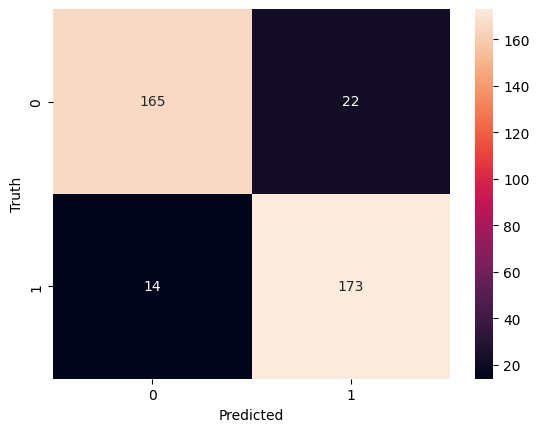

In [43]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [44]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       187
           1       0.89      0.93      0.91       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [ ]:
#primena modela

In [45]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.77182734],
       [0.8706359 ],
       [0.8152603 ],
       [0.16637078],
       [0.07058451]], dtype=float32)